In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from football_sim import *
import os

In [2]:
for x in request_data('/v1/competitions/'):
    print(x['id'],x['caption'])

444 Campeonato Brasileiro da Série A
445 Premier League 2017/18
446 Championship 2017/18
447 League One 2017/18
448 League Two 2017/18
449 Eredivisie 2017/18
450 Ligue 1 2017/18
451 Ligue 2 2017/18
452 1. Bundesliga 2017/18
453 2. Bundesliga 2017/18
455 Primera Division 2017
456 Serie A 2017/18
457 Primeira Liga 2017/18
458 DFB-Pokal 2017/18
459 Serie B 2017/18
464 Champions League 2017/18
466 Australian A-League


In [3]:
a=request_data('/v1/competitions/445/fixtures')['fixtures']

In [23]:
[x for x in  a if 
 pd.to_datetime(x['date'])<pd.to_datetime('today')+pd.Timedelta(1,'D') 
 and x['status']!='FINISHED']

[{'id': 159024,
  'competitionId': 445,
  'date': '2018-03-16T20:00:00Z',
  'status': 'POSTPONED',
  'matchday': 31,
  'homeTeamName': 'Tottenham Hotspur FC',
  'homeTeamId': 73,
  'awayTeamName': 'Newcastle United FC',
  'awayTeamId': 67,
  'result': {'goalsHomeTeam': None, 'goalsAwayTeam': None},
  'odds': None},
 {'id': 159019,
  'competitionId': 445,
  'date': '2018-03-17T15:00:00Z',
  'status': 'POSTPONED',
  'matchday': 31,
  'homeTeamName': 'Leicester City FC',
  'homeTeamId': 338,
  'awayTeamName': 'Arsenal FC',
  'awayTeamId': 57,
  'result': {'goalsHomeTeam': None, 'goalsAwayTeam': None},
  'odds': None},
 {'id': 159023,
  'competitionId': 445,
  'date': '2018-03-17T15:00:00Z',
  'status': 'POSTPONED',
  'matchday': 31,
  'homeTeamName': 'Swansea City FC',
  'homeTeamId': 72,
  'awayTeamName': 'Southampton FC',
  'awayTeamId': 340,
  'result': {'goalsHomeTeam': None, 'goalsAwayTeam': None},
  'odds': None},
 {'id': 159025,
  'competitionId': 445,
  'date': '2018-03-18T13:30:0

In [6]:
LaLigaData=CompetitionResults(455)
PremierLeagueData=CompetitionResults(445,redo=False)
SerieA=CompetitionResults(456)

file exists, loading
file exists, loading
file exists, loading


In [7]:
all_data=dict()
all_data['ES']=LaLigaData.make_df()
all_data['EN']=PremierLeagueData.make_df()
all_data['IT']=SerieA.make_df()

In [8]:
PremierLeagueData.make_df().shape

(351, 5)

In [9]:
calibrator=Calibrator('calibration_other_source.pkl')
for _country in all_data:
    calibrator.process_data(all_data[_country],_country)
teams=calibrator.teams

calibration_other_source.pkl  exists.
file exists, loading
1034


In [10]:
Teams=dict()
League=dict()

In [29]:
country='IT'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage)
League[country].process_current_results(all_data[country])
League[country].simulate_season(n_scenarios=100000)
League[country].season_report()

[ 0.10731498 -0.11504143]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Juventus Turin,93.5,90,97,2,1,68.39,100.00,1.67,0.09,0.00
SSC Napoli,92.4,88,96,2,1,31.61,100.00,1.50,0.12,0.00
SS Lazio,74.8,70,79,5,3,0.00,84.40,1.82,0.49,0.00
AS Roma,74.6,71,79,5,3,0.00,81.85,1.06,0.13,0.00
FC Internazionale Milano,71.9,68,76,5,3,0.00,33.75,0.99,0.19,0.00
Atalanta BC,61.5,57,65,8,6,0.00,0.00,0.96,0.26,0.00
AC Milan,60.3,56,64,9,6,0.00,0.00,0.78,0.29,0.00
UC Sampdoria,57.1,53,61,10,7,0.00,0.00,0.98,0.66,0.00
ACF Fiorentina,56.9,53,61,10,7,0.00,0.00,0.82,0.24,0.00
Torino FC,52.0,48,56,10,9,0.00,0.00,0.84,0.42,0.00


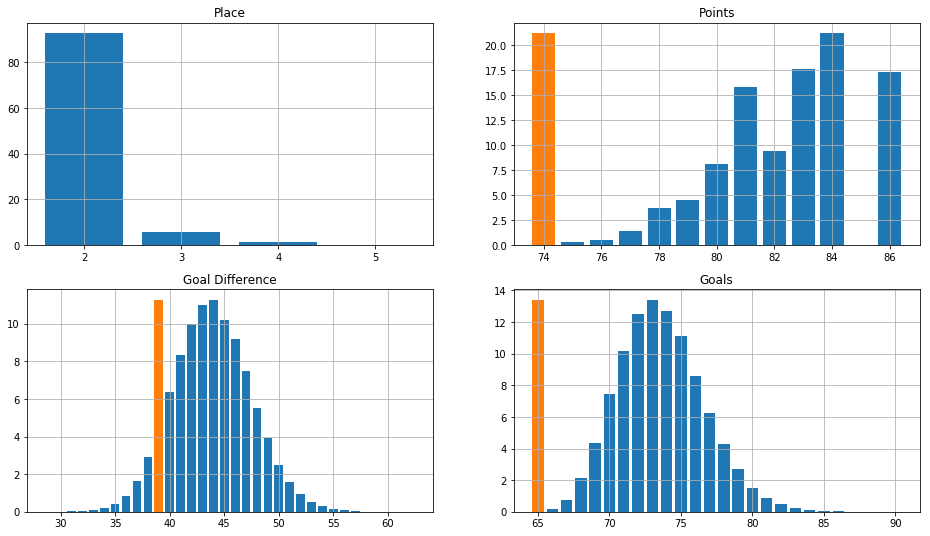

In [17]:
PremierLeague=League['EN']
PremierLeague.team_report('Manchester United FC')

array([ 99.994     , 100.        ,  99.97412789, 100.        ])

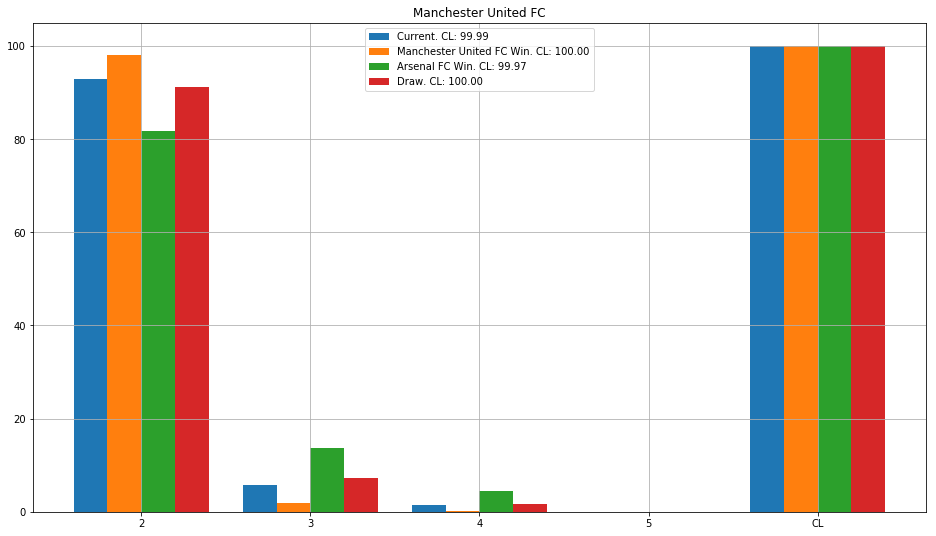

In [25]:
imp=[]
ref_team='Manchester United FC'
#ref_team='Liverpool'
#ref_team='Arsenal'
ref_team = 'SSC Napoli'
_League = League['I']
matches=[]
for x in _League.matches_to_sim:
    matches.append(x)
    pcl=_League.what_if(x,ref_team=ref_team,show_plot=False,place=2,or_better=True)
    #imp.append(pcl.max()/pcl.min())
    imp.append(pcl.std())
    #imp.append(1/pcl.min())
imp=np.array(imp)
matches=np.array(matches)
the_match=matches[imp.argmax()]
the_match = 'Manchester United FC v Arsenal FC'
_League.what_if(the_match,ref_team=ref_team)

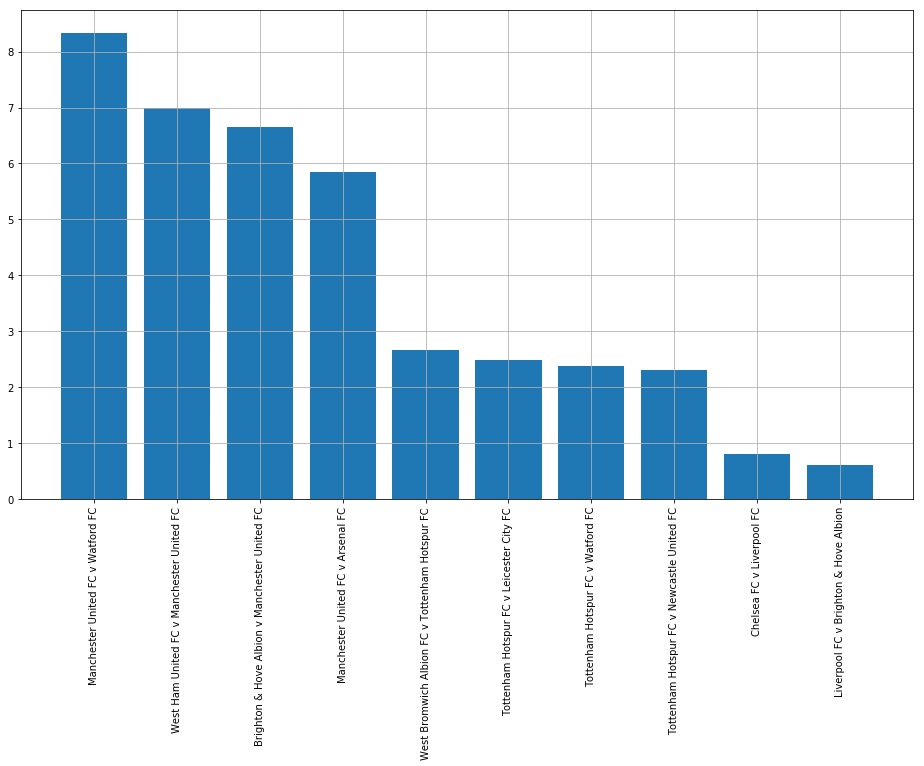

In [21]:
i_sort=(-imp).argsort()
matches=matches[i_sort]
imp=imp[i_sort]
xx=np.arange(10)
plt.bar(xx,imp[xx])
plt.xticks(xx,matches[xx],rotation=90);
plt.grid(True)
fig = plt.gcf()
fig.set_size_inches(16,9)

2.141405


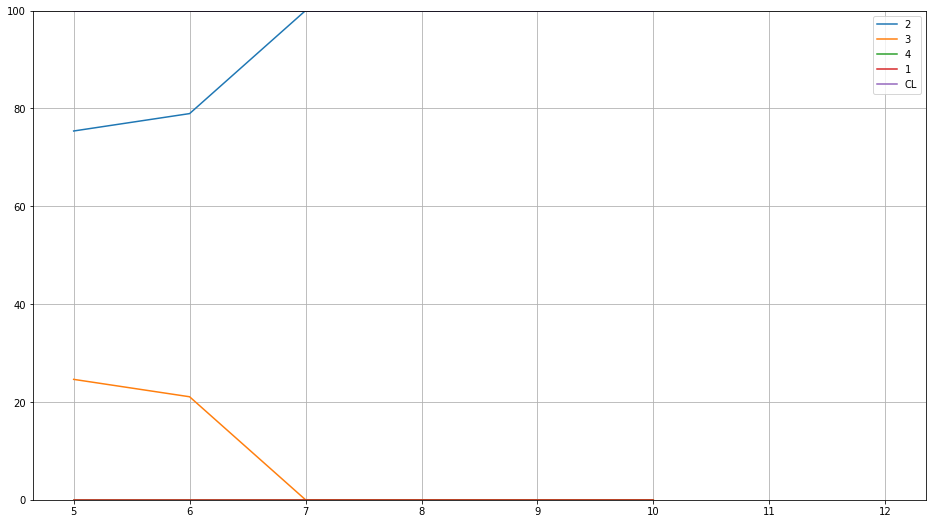

In [28]:
team_name='Manchester United FC'
#team_name='Tottenham'
#team_name='Chelsea'
#team_name='Liverpool'
i=PremierLeague.team_id[team_name]
ind=PremierLeague.place_per_team[i,:]<=4
tmp=[PremierLeague.matches_to_sim[x] for x in PremierLeague.matches_to_sim ]
n=len([x for x in tmp if x['Home']==team_name or x['Away']==team_name])
#pnts=PremierLeague.points_per_team[i,ind]-PremierLeague.current_points['Man United']
pnts=PremierLeague.points_per_team[i,:]-PremierLeague.current_points[team_name]
plc=PremierLeague.place_per_team[i,:]

nrpnts=np.arange(5,3*n+1)
p=np.zeros([nrpnts.shape[0],6])
p[:]=np.nan
for jj in range(nrpnts.shape[0]):
    ind=pnts==nrpnts[jj]
    if ind.any():
        p[jj,0]=(plc[ind]==2).sum()/ind.sum()
        p[jj,1]=(plc[ind]==3).sum()/ind.sum()
        p[jj,2]=(plc[ind]==4).sum()/ind.sum()
        p[jj,3]=(plc[ind]<=4).sum()/ind.sum()
        p[jj,4]=(plc[ind]==1).sum()/ind.sum()
    

plt.plot(nrpnts,100*p[:,0],label='2')
plt.plot(nrpnts,100*p[:,1],label='3')
plt.plot(nrpnts,100*p[:,2],label='4')
plt.plot(nrpnts,100*p[:,4],label='1')
plt.plot(nrpnts,100*p[:,3],label='CL')
plt.legend()
plt.grid(True)
plt.ylim([0,100])
#plt.xlabel([0,3])
print(pnts.mean()/n)
fig = plt.gcf()
fig.set_size_inches(16,9)